### MLP & MNIST
- 使用手动实现的全连接神经网络在 MNIST 数据集上进行训练和验证

#### 1. 导包

In [ ]:
from data_utils import *
import matplotlib.pyplot as plt
import platform
import os
import pickle
import numpy as np
from fcnet import *
from gradient_check import *
from solver import *

np.random.seed(231)

def rel_error(x, y):
    """Returns relative error."""
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

#### 2. 加载MNIST数据集

In [ ]:
data = get_MNIST_data()

print("MNIST数据集信息：")
print("=" * 50)
for k, v in list(data.items()):
    print(f"{k}: {v.shape}")
print("=" * 50)
print(f"\n输入维度: 1 × 28 × 28 = {1*28*28}")
print(f"类别数量: 10 (数字 0-9)")

MNIST数据集信息：
X_train: (55000, 1, 28, 28)
y_train: (55000,)
X_val: (5000, 1, 28, 28)
y_val: (5000,)
X_test: (10000, 1, 28, 28)
y_test: (10000,)

输入维度: 1 × 28 × 28 = 784
类别数量: 10 (数字 0-9)


#### 3. 样本可视化

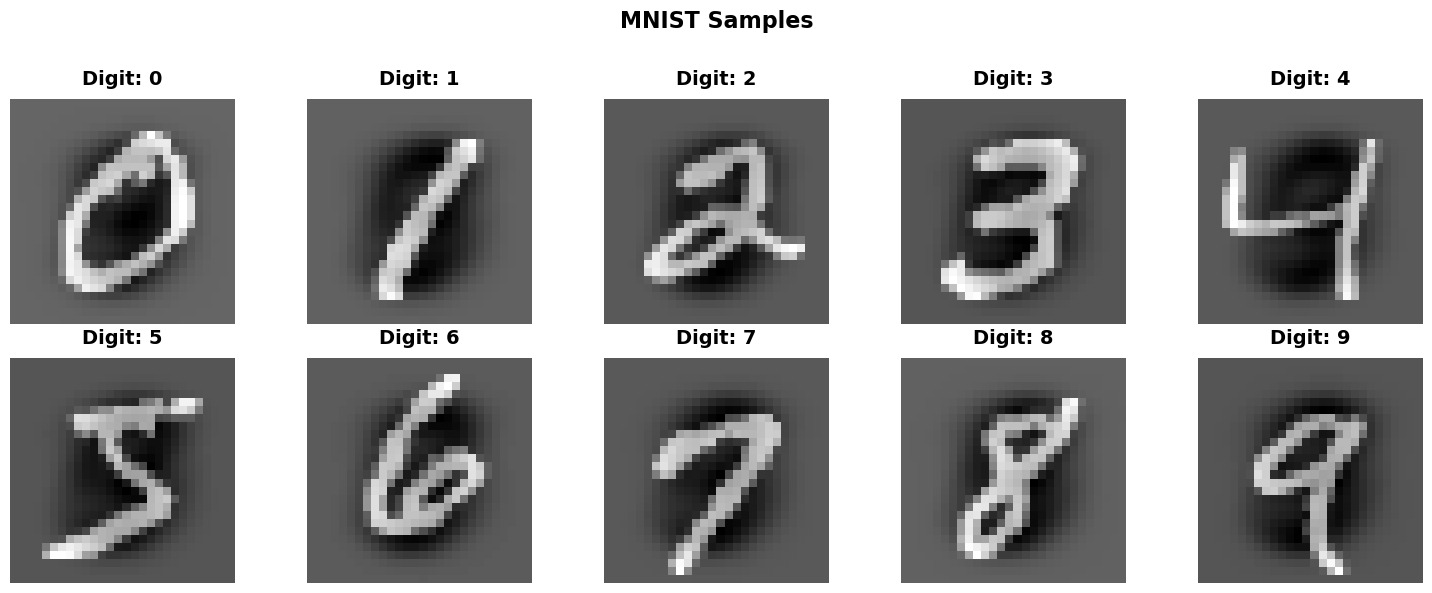

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('MNIST Samples', fontsize=16, fontweight='bold', y=0.98)

samples_shown = {}
for idx, label in enumerate(data['y_train']):
    if label not in samples_shown and label < 10:
        samples_shown[label] = idx
    if len(samples_shown) == 10:
        break

# 绘制每个类别的样本
for digit in range(10):
    row = digit // 5
    col = digit % 5
    
    idx = samples_shown[digit]
    img = data['X_train'][idx][0]  # 形状 (28, 28)
    
    axes[row, col].imshow(img, cmap='gray', interpolation='nearest')
    axes[row, col].set_title(f'Digit: {digit}', fontsize=14, fontweight='bold', pad=10)
    axes[row, col].axis('off')
    
    for spine in axes[row, col].spines.values():
        spine.set_edgecolor('lightgray')
        spine.set_linewidth(2)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### 4. 超参数搜索
- mini 样本集合随机搜索找到最佳的超参数组合

In [ ]:
best_model = None
best_val = -1
best_params = {}

num_train = 1000
small_data = {
    "X_train": data["X_train"][:num_train],
    "y_train": data["y_train"][:num_train],
    "X_val": data["X_val"],
    "y_val": data["y_val"],
}

print("开始超参数搜索...\n")
print("=" * 80)

num_experiments = 20

for i in range(num_experiments):
    # 随机采样超参数
    lr = 10 ** np.random.uniform(-4, -2)   # 学习率
    ws = 10 ** np.random.uniform(-2, -1)   # 权重初始化尺度
    reg = 10 ** np.random.uniform(-4, -1)  # L2正则化系数
    kr = np.random.uniform(0.7, 1.0)       # Dropout保留率

    model = FullyConnectedNet(
        [128, 64],
        input_dim=1*28*28,
        weight_scale=ws,
        reg=reg,
        dropout_keep_ratio=kr,
        normalization='batchnorm'
    )
    
    solver = Solver(
        model, 
        small_data,
        num_epochs=10, 
        batch_size=128,
        update_rule='adam',
        optim_config={'learning_rate': lr},
        verbose=False
    )

    solver.train()
    new_val = solver.best_val_acc

    if new_val > best_val:
        best_val = new_val
        best_params = {'lr': lr, 'ws': ws, 'reg': reg, 'kr': kr}

    print(f"实验 {i+1:2d}: lr={lr:.5f}, ws={ws:.5f}, reg={reg:.5f}, kr={kr:.3f} -> val_acc={new_val:.4f}")

print("\n" + "=" * 80)
print(f"最佳验证准确率: {best_val:.4f}")
print(f"\n最佳超参数:")
print(f"  学习率 (lr):        {best_params['lr']:.6f}")
print(f"  权重尺度 (ws):      {best_params['ws']:.6f}")
print(f"  正则化 (reg):       {best_params['reg']:.6f}")
print(f"  Dropout保留率 (kr): {best_params['kr']:.4f}")
print("=" * 80)

开始超参数搜索...

实验  1: lr=0.00057, ws=0.01185, reg=0.03614, kr=0.858 -> val_acc=0.9492
实验  2: lr=0.00125, ws=0.01141, reg=0.06663, kr=0.763 -> val_acc=0.9388
实验  3: lr=0.00142, ws=0.01871, reg=0.00270, kr=0.814 -> val_acc=0.9538
实验  4: lr=0.00016, ws=0.03710, reg=0.00508, kr=0.778 -> val_acc=0.9258
实验  5: lr=0.00111, ws=0.02473, reg=0.00080, kr=0.702 -> val_acc=0.9508
实验  6: lr=0.00038, ws=0.03368, reg=0.00024, kr=0.770 -> val_acc=0.9440
实验  7: lr=0.00236, ws=0.08140, reg=0.00908, kr=0.701 -> val_acc=0.9482
实验  8: lr=0.00016, ws=0.01607, reg=0.00089, kr=0.730 -> val_acc=0.9304
实验  9: lr=0.00016, ws=0.07492, reg=0.02608, kr=0.992 -> val_acc=0.9158
实验 10: lr=0.00012, ws=0.08383, reg=0.00098, kr=0.892 -> val_acc=0.8770
实验 11: lr=0.00925, ws=0.01244, reg=0.03056, kr=0.728 -> val_acc=0.8696
实验 12: lr=0.00237, ws=0.02954, reg=0.00321, kr=0.896 -> val_acc=0.9566
实验 13: lr=0.00060, ws=0.03681, reg=0.00011, kr=0.968 -> val_acc=0.9488
实验 14: lr=0.00230, ws=0.01233, reg=0.03377, kr=0.882 -> val_acc=0

#### 5. 完整训练

In [ ]:
# 创建最佳模型
best_model = FullyConnectedNet(
    [256,  128, 64],  # 使用更深的网络
    input_dim=1*28*28,
    weight_scale=best_params['ws'],
    reg=best_params['reg'],
    dropout_keep_ratio=best_params['kr'],
    normalization='batchnorm'
)

solver = Solver(
    best_model, 
    data,
    num_epochs=20, 
    batch_size=256,
    update_rule='adam',
    optim_config={'learning_rate': best_params['lr']},
    lr_decay=0.95,
    verbose=True,
    print_every=100
)

num_train = solver.X_train.shape[0]
iterations_per_epoch = max(num_train // solver.batch_size, 1)
num_iterations = solver.num_epochs * iterations_per_epoch
check_interval = iterations_per_epoch // 4  # 每个epoch检查4次

# 存储准历史
train_acc_detailed = []
val_acc_detailed = []
acc_iteration_points = []

for t in range(num_iterations):
    solver._step()
    
    if solver.verbose and t % solver.print_every == 0:
        print(f"(Iteration {t + 1} / {num_iterations}) loss: {solver.loss_history[-1]:.4f}")
    
    if t % check_interval == 0 or t == num_iterations - 1:
        train_acc = solver.check_accuracy(solver.X_train, solver.y_train, num_samples=solver.num_train_samples)
        val_acc = solver.check_accuracy(solver.X_val, solver.y_val, num_samples=solver.num_val_samples)
        train_acc_detailed.append(train_acc)
        val_acc_detailed.append(val_acc)
        acc_iteration_points.append(t + 1)
        
        if solver.verbose and t % (check_interval * 2) == 0:  # 减少打印频率
            print(f"  -> train acc: {train_acc:.4f}; val_acc: {val_acc:.4f}")

    epoch_end = (t + 1) % iterations_per_epoch == 0
    if epoch_end:
        solver.epoch += 1
        for k in solver.optim_configs:
            solver.optim_configs[k]["learning_rate"] *= solver.lr_decay

        if val_acc_detailed[-1] > solver.best_val_acc:
            solver.best_val_acc = val_acc_detailed[-1]
            solver.best_params = {}
            for k, v in solver.model.params.items():
                solver.best_params[k] = v.copy()

solver.model.params = solver.best_params

print(f"\n训练完成！")
print(f"最佳验证准确率: {solver.best_val_acc:.4f}")

使用最佳超参数在完整数据集上训练...

(Iteration 1 / 4280) loss: 2.6408
  -> train acc: 0.1030; val_acc: 0.1094
(Iteration 101 / 4280) loss: 0.4399
  -> train acc: 0.9270; val_acc: 0.9530
(Iteration 201 / 4280) loss: 0.3914
  -> train acc: 0.9430; val_acc: 0.9582
(Iteration 301 / 4280) loss: 0.3313
  -> train acc: 0.9410; val_acc: 0.9690
(Iteration 401 / 4280) loss: 0.3549
  -> train acc: 0.9650; val_acc: 0.9670
(Iteration 501 / 4280) loss: 0.2747
  -> train acc: 0.9600; val_acc: 0.9586
(Iteration 601 / 4280) loss: 0.3689
  -> train acc: 0.9700; val_acc: 0.9710
(Iteration 701 / 4280) loss: 0.2590
  -> train acc: 0.9690; val_acc: 0.9728
(Iteration 801 / 4280) loss: 0.2406
  -> train acc: 0.9670; val_acc: 0.9716
(Iteration 901 / 4280) loss: 0.3084
  -> train acc: 0.9760; val_acc: 0.9670
(Iteration 1001 / 4280) loss: 0.2899
  -> train acc: 0.9690; val_acc: 0.9716
(Iteration 1101 / 4280) loss: 0.2656
  -> train acc: 0.9730; val_acc: 0.9726
(Iteration 1201 / 4280) loss: 0.2966
  -> train acc: 0.9680; val_ac

#### 6. 训练可视化

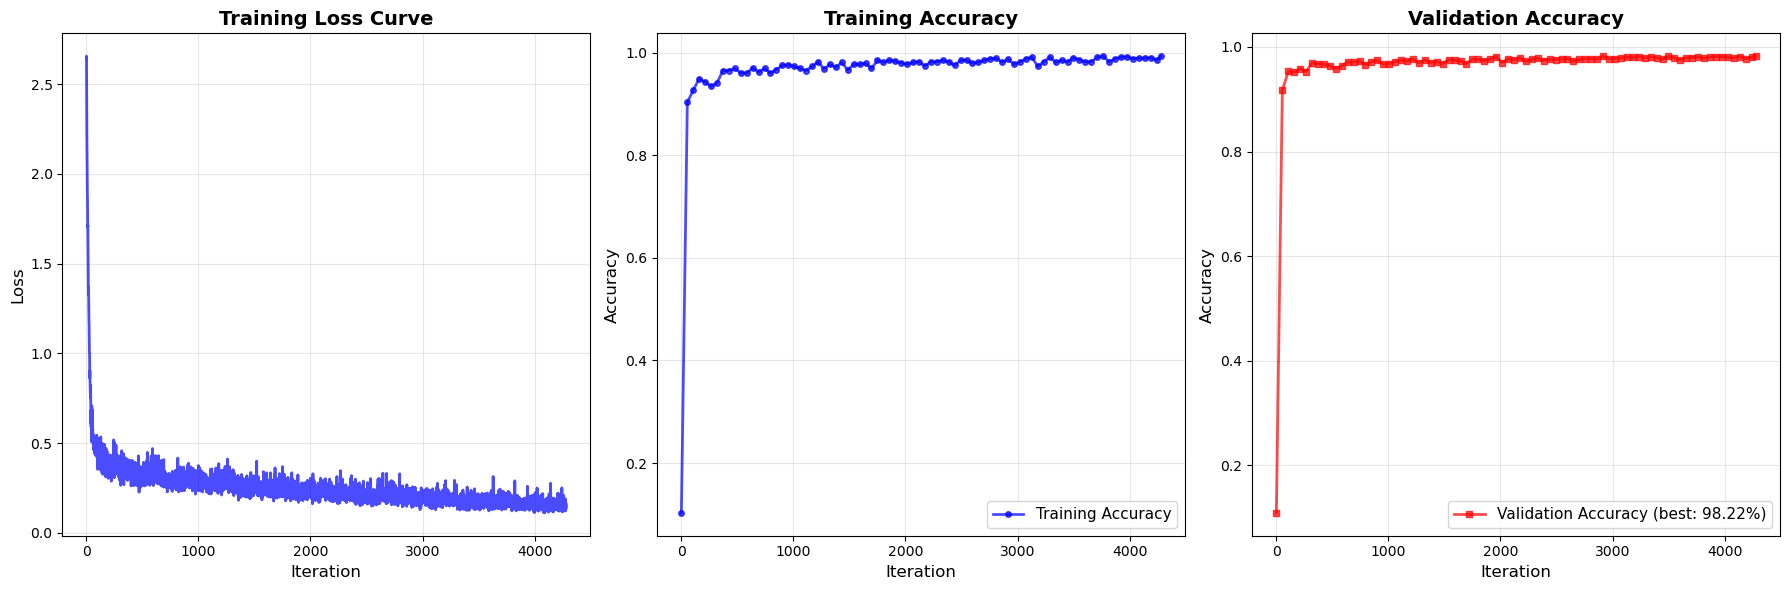

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

iterations_range = range(1, len(solver.loss_history) + 1)

axes[0].plot(range(1, len(solver.loss_history) + 1), solver.loss_history, 'b-', alpha=0.7, linewidth=2)
axes[0].set_xlabel('Iteration', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss Curve', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].plot(acc_iteration_points, train_acc_detailed, 'b-', marker='o', 
             alpha=0.7, label='Training Accuracy', linewidth=2, markersize=4)
axes[1].set_xlabel('Iteration', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

best_val_acc = max(val_acc_detailed)
axes[2].plot(acc_iteration_points, val_acc_detailed, 'r-', marker='s', 
             alpha=0.7, label=f'Validation Accuracy (best: {best_val_acc:.2%})', 
             linewidth=2, markersize=4)
axes[2].set_xlabel('Iteration', fontsize=12)
axes[2].set_ylabel('Accuracy', fontsize=12)
axes[2].set_title('Validation Accuracy', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()